# Summer analysis 2023: ndvi+ndmi+marginalization res 10

This notebook joins ndvi (res10), ndmi (res10) and marginalization (res8 to res10 through centroids) and creates categories for NDVI and marg in order to create the following analysis:

Analysis 1: (CSV) Average ndvi and ndmi min, median, mean, max data by marginalization group.

Analysis 2: (MAP, BOXPLOT) Zones that may recieve irrigation within urban spaces and its relation with marginalization. Places without vegetation are discarted.(ndvi without locations with water, marshy surfaces, artificial structures, rocks adn clouds).

Analysis 3: (CSV) From analisis 2, ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min) are located, ploted and exported to csv.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [2]:
city = 'ZMVM'

In [38]:
#Save csvs to output>figures>ndmi_ndmi_marg_bycity?
csv_dataset = True 
#"averagerasterdata_bymarg": csv containing ndvi and ndmi min, mean, median and max, along with the marginalization category
#"ndmi_diffextremes_marg": csv containing the top 10% and bottom 10% ndmi_diff (humidity variation/conservation) related to the marginalization degree.

#Save figures to output>figures>ndmi_ndmi_marg_bycity?
save_plots = True

## Data download

Data download - NDVI

In [4]:
# Downloading NDVI res 10 data
ndvi_schema = 'raster_analysis'
ndvi_folder = 'ndvi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndvi_schema}.{ndvi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndvi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndvi_res10.shape)
ndvi_res10.head(2)

(52430, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a4995bab2dffff,"POLYGON ((-99.20943 19.48627, -99.20878 19.486...",10,0.252514,0.080016,0.276159,0.337690,0.124392,0.213298,-0.000920,ZMVM
1,8a4995b8c00ffff,"POLYGON ((-99.18298 19.48495, -99.18233 19.485...",10,0.104922,0.040548,0.119599,0.136367,0.026102,0.110265,-0.000638,ZMVM


Data download - NDMI

In [5]:
# Downloading NDMI res 10 data
ndmi_schema = 'raster_analysis'
ndmi_folder = 'ndmi_analysis_hex'

res = 10

query = f"SELECT * FROM {ndmi_schema}.{ndmi_folder} WHERE \"city\" LIKE \'{city}\' AND \"res\"={res}"
ndmi_res10 = aup.gdf_from_query(query, geometry_col='geometry')

print(ndmi_res10.shape)
ndmi_res10.head(2)

(52430, 11)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,city
0,8a4995bab22ffff,"POLYGON ((-99.21181 19.48165, -99.21116 19.482...",10,-0.007643,0.047608,-0.010243,0.075942,-0.067931,0.143873,-0.000275,ZMVM
1,8a4995b81a9ffff,"POLYGON ((-99.16786 19.47167, -99.16721 19.472...",10,0.108321,0.034522,0.107008,0.169838,0.070698,0.099141,-0.000502,ZMVM


Data download - Municipalities (in order to download marginalization)

In [6]:
mun_schema = 'metropolis'
mun_table = 'metro_gdf'

query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

#---------------------------------------------------- CDMX data filter ----------------------------------------------------
if city == 'ZMVM':
    #Identify cdmx municipalities
    municipalities = ['Azcapotzalco','Coyoacán','Cuajimalpa de Morelos','Gustavo A. Madero', 'Iztacalco', 'Iztapalapa','La Magdalena Contreras', 
                      'Milpa Alta', 'Álvaro Obregón','Tláhuac', 'Tlalpan', 'Xochimilco', 'Benito Juárez', 'Cuauhtémoc','Miguel Hidalgo', 'Venustiano Carranza']
    mun_gdf['city2'] = mun_gdf['NOMGEO'].apply(lambda x: 'cdmx' if x in municipalities else 'zmvm')
    
    #Keep cdmx municipalities only
    mun_gdf = mun_gdf.loc[mun_gdf['city2']=='cdmx']
    mun_gdf.drop(columns=['city2'],inplace=True)
#---------------------------------------------------- CDMX data filter ----------------------------------------------------
    
print(mun_gdf.shape)
mun_gdf.head(2)

(16, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,09002,09,002,Azcapotzalco,"POLYGON ((-99.18231 19.50748, -99.18229 19.507...",ZMVM
1,09003,09,003,Coyoacán,"POLYGON ((-99.13427 19.35654, -99.13397 19.356...",ZMVM


Data download - Marginalization

In [7]:
cvegeo_list = list(mun_gdf.loc[mun_gdf.city==city]["CVEGEO"].unique())
cvegeo_list

['09002',
 '09003',
 '09004',
 '09005',
 '09006',
 '09007',
 '09008',
 '09009',
 '09010',
 '09011',
 '09012',
 '09013',
 '09014',
 '09015',
 '09016',
 '09017']

In [8]:
# donwload hexagons with marg data
hex_marg = gpd.GeoDataFrame()
marg_table = 'hex_bins_marg_2020'
marg_schema = 'censo'


# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    hex_marg = pd.concat([hex_marg, hex_tmp],
    ignore_index = True, axis = 0)
print(hex_marg.shape)
hex_marg.head(2)

(1065, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-99.17740 19.48241, -99.17776 19.487...",884995b8c1fffff,09002,14474.150,11.159615,39.639160,60.006165,0.094840,0.109755,0.752394,0.921807,8.358856,45.407722,16.135150,54.746320,123.545098,0.965088
1,"POLYGON ((-99.17884 19.50300, -99.17848 19.497...",884995b88dfffff,09002,5324.688,12.022201,22.668638,27.020708,0.101111,0.016225,5.099980,1.091457,5.453633,28.146427,7.906191,28.952435,123.916076,0.967986


## Data treatment

### Data treatment - Bring marginalization data (res8) and mun_gdf CVENOM to ndvi (res10)

Find ndvi centroids in order to intersect res10 info with a single res8 hex

In [17]:
#Find centroids
ndvi_res10_calc = ndvi_res10.to_crs("EPSG:6372")
centroids = ndvi_res10_calc.centroid
centroids = centroids.to_crs("EPSG:4326")

#Turn into gdf
centroids_gdf = gpd.GeoDataFrame(centroids)
centroids_gdf = centroids_gdf.rename(columns={0:'geometry'})

#Review result
print(centroids_gdf.shape)
centroids_gdf.head(2)

(52430, 1)


,geometry
0,POINT (-99.20948 19.48701)
1,POINT (-99.18303 19.48568)


Intersect centroids with orginal ndvi data to keep hex_id data

In [18]:
centroids_hexid10 = gpd.overlay(centroids_gdf,ndvi_res10,keep_geom_type=True)

columns_tokeep = ['hex_id','geometry']
centroids_hexid10 = centroids_hexid10[columns_tokeep]

#Review result
print(centroids_hexid10.shape)
centroids_hexid10.head(2)

(52430, 2)


,hex_id,geometry
0,8a4995bab2dffff,POINT (-99.20948 19.48701)
1,8a4995b8c00ffff,POINT (-99.18303 19.48568)


Intersect ndvi centroids with marginalization data

In [19]:
centroids_hexid10_marg = gpd.overlay(centroids_hexid10,hex_marg,keep_geom_type=True)

columns_tokeep = ['hex_id','pobtot','im_2020','imn_2020','geometry']
centroids_hexid10_marg = centroids_hexid10_marg[columns_tokeep]

#Review result
print(centroids_hexid10_marg.shape)
centroids_hexid10_marg.head(2)

(52185, 5)


,hex_id,pobtot,im_2020,imn_2020,geometry
0,8a4995bab2dffff,15549.079,123.028312,0.961051,POINT (-99.20948 19.48701)
1,8a4995b8d847fff,15549.079,123.028312,0.961051,POINT (-99.20919 19.49257)


Intersect centroids_hexid10_marg with mungdf

In [22]:
mun_gdf = mun_gdf.set_crs("EPSG:4326")
centroids_hexid10_marg_mun = gpd.overlay(centroids_hexid10_marg,mun_gdf,keep_geom_type=True)

columns_tokeep = ['hex_id','pobtot','im_2020','imn_2020','NOMGEO']
centroids_hexid10_marg_mun = centroids_hexid10_marg_mun[columns_tokeep]

#Review result
print(centroids_hexid10_marg_mun.shape)
centroids_hexid10_marg_mun.head(2)

(51474, 5)


,hex_id,pobtot,im_2020,imn_2020,NOMGEO
0,8a4995bab2dffff,15549.079,123.028312,0.961051,Azcapotzalco
1,8a4995b8d847fff,15549.079,123.028312,0.961051,Azcapotzalco


Merge centroids_marg back with res10 geometry with hex_id

In [24]:
ndvi_marg = pd.merge(ndvi_res10,centroids_hexid10_marg_mun, on='hex_id')

#Review result
print(ndvi_marg.shape)
ndvi_marg.head(2)

(51474, 15)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,pobtot,im_2020,imn_2020,NOMGEO
0,8a4995bab2dffff,"POLYGON ((-99.20943 19.48627, -99.20878 19.486...",10,0.252514,0.080016,0.276159,0.337690,0.124392,0.213298,-0.000920,ZMVM,15549.079,123.028312,0.961051,Azcapotzalco
1,8a4995b8c00ffff,"POLYGON ((-99.18298 19.48495, -99.18233 19.485...",10,0.104922,0.040548,0.119599,0.136367,0.026102,0.110265,-0.000638,ZMVM,14474.150,123.545098,0.965088,Azcapotzalco


### Data treatment - Merge NDVI_MARG with NDMI

In [25]:
ndmi_res10_clean = ndmi_res10.drop(columns=['geometry','res','city'])
ndvi_ndmi_marg = ndvi_marg.merge(ndmi_res10_clean, left_on='hex_id', right_on='hex_id')

#Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(51474, 22)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,im_2020,imn_2020,NOMGEO,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend
0,8a4995bab2dffff,"POLYGON ((-99.20943 19.48627, -99.20878 19.486...",10,0.252514,0.080016,0.276159,0.337690,0.124392,0.213298,-0.000920,...,123.028312,0.961051,Azcapotzalco,0.052007,0.041681,0.044277,0.123271,0.001501,0.121770,-0.000578
1,8a4995b8c00ffff,"POLYGON ((-99.18298 19.48495, -99.18233 19.485...",10,0.104922,0.040548,0.119599,0.136367,0.026102,0.110265,-0.000638,...,123.545098,0.965088,Azcapotzalco,-0.029038,0.045319,-0.043123,0.067063,-0.066244,0.133307,0.000269


### Data treatment - Create data categories

Data treatment - Creating vegetation categories

In [26]:
# Creating vegetation categories
ndvi_ndmi_marg['ndvi_median_rango'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.4 )&
             (ndvi_ndmi_marg.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.2)&
             (ndvi_ndmi_marg.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median>=0.1)&
             (ndvi_ndmi_marg.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'

# Ordering data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_ndmi_marg['ndvi_median_rango'] = pd.Categorical(ndvi_ndmi_marg['ndvi_median_rango'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(51474, 23)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,imn_2020,NOMGEO,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango
0,8a4995bab2dffff,"POLYGON ((-99.20943 19.48627, -99.20878 19.486...",10,0.252514,0.080016,0.276159,0.337690,0.124392,0.213298,-0.000920,...,0.961051,Azcapotzalco,0.052007,0.041681,0.044277,0.123271,0.001501,0.121770,-0.000578,Mínima densidad vegetal
1,8a4995b8c00ffff,"POLYGON ((-99.18298 19.48495, -99.18233 19.485...",10,0.104922,0.040548,0.119599,0.136367,0.026102,0.110265,-0.000638,...,0.965088,Azcapotzalco,-0.029038,0.045319,-0.043123,0.067063,-0.066244,0.133307,0.000269,Suelo


Reviewing ndvi proportions

In [27]:
ndviproportions = ndvi_ndmi_marg.groupby('ndvi_median_rango').count()

columns_tokeep = ['hex_id']
ndviproportions = ndviproportions[columns_tokeep]

ndviproportions = ndviproportions.rename(columns={'hex_id':'count'})
ndviproportions['%'] = ndviproportions['count'].apply(lambda x: (x/(ndviproportions['count'].sum()))*100)

ndviproportions

,count,%
ndvi_median_rango,,
Suelo artificial/Agua/Piedra,9716,18.875549
Suelo,15860,30.811672
Mínima densidad vegetal,21243,41.269379
Moderada densidad vegetal,4375,8.499437
Alta densidad vegetal,280,0.543964


Data treatment - Creating marginalization categories

In [28]:
ndvi_ndmi_marg['Grado_Marg'] = np.nan
ndvi_ndmi_marg.loc[ndvi_ndmi_marg.imn_2020>=0.966338 , 'Grado_Marg'] = 'Muy bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.946436 )&
             (ndvi_ndmi_marg.imn_2020<0.966338), 'Grado_Marg'] = 'Bajo'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.926536)&
             (ndvi_ndmi_marg.imn_2020<0.946436), 'Grado_Marg'] = 'Medio'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020>=0.8999)&
             (ndvi_ndmi_marg.imn_2020<0.926536), 'Grado_Marg'] = 'Alto'
ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.imn_2020<0.8999), 'Grado_Marg'] = 'Muy Alto'

categories = ['Muy Alto', 'Alto', 'Medio', 'Bajo', 'Muy bajo']
ndvi_ndmi_marg['Grado_Marg'] = pd.Categorical(ndvi_ndmi_marg['Grado_Marg'], categories=categories, ordered=True)

# Reviewing process
print(ndvi_ndmi_marg.shape)
ndvi_ndmi_marg.head(2)

(51474, 24)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,NOMGEO,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a4995bab2dffff,"POLYGON ((-99.20943 19.48627, -99.20878 19.486...",10,0.252514,0.080016,0.276159,0.337690,0.124392,0.213298,-0.000920,...,Azcapotzalco,0.052007,0.041681,0.044277,0.123271,0.001501,0.121770,-0.000578,Mínima densidad vegetal,Bajo
1,8a4995b8c00ffff,"POLYGON ((-99.18298 19.48495, -99.18233 19.485...",10,0.104922,0.040548,0.119599,0.136367,0.026102,0.110265,-0.000638,...,Azcapotzalco,-0.029038,0.045319,-0.043123,0.067063,-0.066244,0.133307,0.000269,Suelo,Bajo


Reviewing marg proportions

In [29]:
margproportions = ndvi_ndmi_marg.groupby('Grado_Marg').count()

columns_tokeep = ['hex_id']
margproportions = margproportions[columns_tokeep]

margproportions = margproportions.rename(columns={'hex_id':'count'})
margproportions['%'] = margproportions['count'].apply(lambda x: (x/(margproportions['count'].sum()))*100)

margproportions

,count,%
Grado_Marg,,
Muy Alto,727,1.412364
Alto,4319,8.390644
Medio,13989,27.176827
Bajo,22864,44.418541
Muy bajo,9575,18.601624


## Analysis 1a - Average min, mean, median, max data by marginalization group

In [32]:
# Group by calculating min, mean, median and max ndvi and ndmi for each marginalization group
marginalization_behaviour = ndvi_ndmi_marg.groupby('Grado_Marg').agg({'ndvi_min':np.mean,'ndvi_mean':np.mean,'ndvi_median':np.mean,'ndvi_max':np.mean,
                                                                      'ndmi_min':np.mean,'ndmi_mean':np.mean,'ndmi_median':np.mean,'ndmi_max':np.mean})

# Calculate the summary statistics across columns
summary_df = pd.DataFrame({
    'ndvi_min': pd.Series(ndvi_ndmi_marg['ndvi_min'].mean(), index=['Todos los hex']),
    'ndvi_mean': pd.Series(ndvi_ndmi_marg['ndvi_mean'].mean(), index=['Todos los hex']),
    'ndvi_median': pd.Series(ndvi_ndmi_marg['ndvi_median'].mean(), index=['Todos los hex']),
    'ndvi_max': pd.Series(ndvi_ndmi_marg['ndvi_max'].mean(), index=['Todos los hex']),
    'ndmi_min': pd.Series(ndvi_ndmi_marg['ndmi_min'].mean(), index=['Todos los hex']),
    'ndmi_mean': pd.Series(ndvi_ndmi_marg['ndmi_mean'].mean(), index=['Todos los hex']),
    'ndmi_median': pd.Series(ndvi_ndmi_marg['ndmi_median'].mean(), index=['Todos los hex']),
    'ndmi_max': pd.Series(ndvi_ndmi_marg['ndmi_max'].mean(), index=['Todos los hex'])
})

# Append the summary row to the original dataframe
marginalization_behaviour_with_summary = pd.concat([marginalization_behaviour, summary_df])

# Rename columns to clarify that they represent the mean values of each category
marginalization_behaviour_with_summary.rename(columns={
    'ndvi_min': 'avg ndvi_min',
    'ndvi_mean': 'avg ndvi_mean',
    'ndvi_median': 'avg ndvi_median',
    'ndvi_max': 'avg ndvi_max',
    'ndmi_min': 'avg ndmi_min',
    'ndmi_mean': 'avg ndmi_mean',
    'ndmi_median': 'avg ndmi_median',
    'ndmi_max': 'avg ndmi_max'},inplace=True)

marginalization_behaviour_with_summary

,avg ndvi_min,avg ndvi_mean,avg ndvi_median,avg ndvi_max,avg ndmi_min,avg ndmi_mean,avg ndmi_median,avg ndmi_max
Muy Alto,0.113580,0.323586,0.304646,0.537621,-0.097657,0.041799,0.031111,0.216351
Alto,0.113800,0.312845,0.300214,0.511699,-0.073187,0.051123,0.042048,0.210330
Medio,0.082404,0.230506,0.231178,0.358591,-0.058332,0.025714,0.014629,0.156921
Bajo,0.075070,0.178315,0.188367,0.251630,-0.047886,0.007081,-0.004546,0.119902
Muy bajo,0.100233,0.215221,0.236745,0.287876,-0.013710,0.034696,0.025087,0.130635
Todos los hex,0.085537,0.212704,0.220028,0.313302,-0.047193,0.021468,0.010591,0.140909


In [33]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = marginalization_behaviour_with_summary.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/averagerasterdata_bymarg_{}.csv".format(city.lower(),city.lower()))

(6, 8)


## Analysis 1b - Average min, mean, median, max data by municipality

In [34]:
# Group by calculating min, mean, median and max ndvi and ndmi for each marginalization group
municipalities_behaviour = ndvi_ndmi_marg.groupby('NOMGEO').agg({'ndvi_min':np.mean,'ndvi_mean':np.mean,'ndvi_median':np.mean,'ndvi_max':np.mean,
                                                                 'ndmi_min':np.mean,'ndmi_mean':np.mean,'ndmi_median':np.mean,'ndmi_max':np.mean})

# Calculate the summary statistics across columns
summary_df = pd.DataFrame({
    'ndvi_min': pd.Series(ndvi_ndmi_marg['ndvi_min'].mean(), index=['Todos los hex']),
    'ndvi_mean': pd.Series(ndvi_ndmi_marg['ndvi_mean'].mean(), index=['Todos los hex']),
    'ndvi_median': pd.Series(ndvi_ndmi_marg['ndvi_median'].mean(), index=['Todos los hex']),
    'ndvi_max': pd.Series(ndvi_ndmi_marg['ndvi_max'].mean(), index=['Todos los hex']),
    'ndmi_min': pd.Series(ndvi_ndmi_marg['ndmi_min'].mean(), index=['Todos los hex']),
    'ndmi_mean': pd.Series(ndvi_ndmi_marg['ndmi_mean'].mean(), index=['Todos los hex']),
    'ndmi_median': pd.Series(ndvi_ndmi_marg['ndmi_median'].mean(), index=['Todos los hex']),
    'ndmi_max': pd.Series(ndvi_ndmi_marg['ndmi_max'].mean(), index=['Todos los hex'])
})

# Append the summary row to the original dataframe
municipalities_behaviour_with_summary = pd.concat([municipalities_behaviour, summary_df])

# Rename columns to clarify that they represent the mean values of each category
municipalities_behaviour_with_summary.rename(columns={
    'ndvi_min': 'avg ndvi_min',
    'ndvi_mean': 'avg ndvi_mean',
    'ndvi_median': 'avg ndvi_median',
    'ndvi_max': 'avg ndvi_max',
    'ndmi_min': 'avg ndmi_min',
    'ndmi_mean': 'avg ndmi_mean',
    'ndmi_median': 'avg ndmi_median',
    'ndmi_max': 'avg ndmi_max'},inplace=True)

municipalities_behaviour_with_summary

,avg ndvi_min,avg ndvi_mean,avg ndvi_median,avg ndvi_max,avg ndmi_min,avg ndmi_mean,avg ndmi_median,avg ndmi_max
Azcapotzalco,0.039137,0.122739,0.136775,0.169680,-0.051529,-0.010317,-0.023367,0.091970
Benito Juárez,0.067847,0.148592,0.172207,0.195818,-0.028707,0.008789,-0.002245,0.098150
Coyoacán,0.102271,0.207236,0.226325,0.272628,-0.022803,0.023157,0.012933,0.129073
Cuajimalpa de Morelos,0.091848,0.312209,0.329408,0.462822,0.020873,0.105729,0.102343,0.204137
Cuauhtémoc,0.039028,0.120408,0.137057,0.163254,-0.049667,-0.012899,-0.024456,0.088081
Gustavo A. Madero,0.035196,0.141723,0.146599,0.225019,-0.067829,-0.008826,-0.022879,0.121609
Iztacalco,0.033505,0.107283,0.120394,0.147472,-0.061088,-0.023799,-0.035478,0.081802
Iztapalapa,0.042494,0.117175,0.122429,0.176458,-0.074875,-0.027111,-0.040884,0.090529
La Magdalena Contreras,0.127735,0.262119,0.283692,0.343225,-0.006350,0.051320,0.040672,0.155097
Miguel Hidalgo,0.108259,0.233832,0.256955,0.315895,-0.004890,0.046022,0.038878,0.133527


In [35]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = municipalities_behaviour_with_summary.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/averagerasterdata_bymunicipality_{}.csv".format(city.lower(),city.lower()))

(17, 8)


## Analysis 2 - Zones that may recieve irrigation within urban spaces (ndmi_diff analysis) and its relation with marginalization

### Anlysis 2 Data treatment - Filter for places with vegetation

NDVI filtering for places with vegetation

In [36]:
#Keeping High-moderate-minimal vegetation density
data_withveg = ndvi_ndmi_marg.loc[(ndvi_ndmi_marg.ndvi_median_rango == 'Alta densidad vegetal') |
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Moderada densidad vegetal')|
                   (ndvi_ndmi_marg.ndvi_median_rango == 'Mínima densidad vegetal')]

#Reviewing process
print(data_withveg.shape)
data_withveg.head(2)

(25898, 24)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,NOMGEO,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg
0,8a4995bab2dffff,"POLYGON ((-99.20943 19.48627, -99.20878 19.486...",10,0.252514,0.080016,0.276159,0.337690,0.124392,0.213298,-0.000920,...,Azcapotzalco,0.052007,0.041681,0.044277,0.123271,0.001501,0.121770,-0.000578,Mínima densidad vegetal,Bajo
15,8a4995b8c1a7fff,"POLYGON ((-99.17998 19.48074, -99.17933 19.481...",10,0.251384,0.095305,0.285311,0.349759,0.095910,0.253849,-0.000768,...,Azcapotzalco,0.067400,0.041817,0.063828,0.150232,0.021499,0.128733,-0.001098,Mínima densidad vegetal,Bajo


### Analysis 2 Data analysis [a] - Visual correlation analyisis

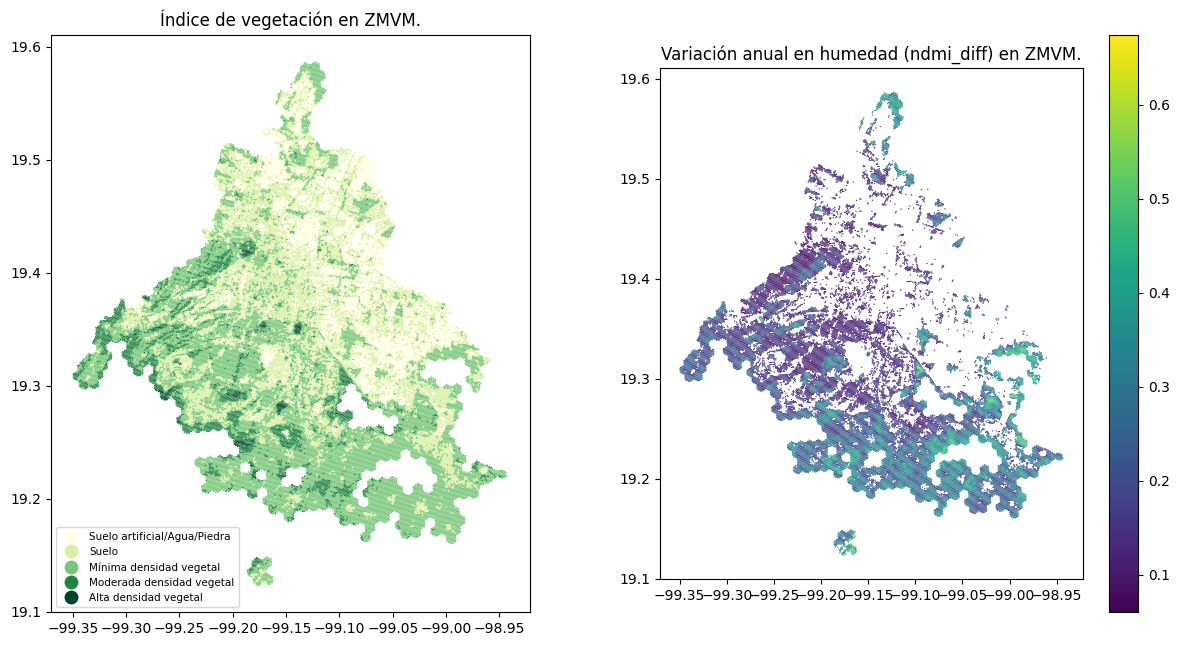

In [39]:
fig, ax = plt.subplots(1,2,figsize=(15,7.5))

#---------- Ax 0 ----------
ax[0].set_title('Índice de vegetación en {}.'.format(city))
ndvi_ndmi_marg.plot('ndvi_median_rango', 'YlGn', ax=ax[0],legend=True,
                    legend_kwds={'fontsize':7.5,'loc':'lower left'})

#---------- Ax 1 ----------
ax[1].set_title('Variación anual en humedad (ndmi_diff) en {}.'.format(city))
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[1], legend=True)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_{}.svg".format(city.lower(),city.lower()))

### Analysis 2 Data analysis [b] - Boxplot

In [40]:
boxplot_gdf = ndvi_ndmi_marg.copy()
boxplot_gdf = boxplot_gdf.sort_values('Grado_Marg')
boxplot_gdf.loc[boxplot_gdf.Grado_Marg.isna()]

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,NOMGEO,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg


      index  Grado_Marg
4  Muy Alto         727
3      Alto        4319
1     Medio       13989
0      Bajo       22864
2  Muy bajo        9575


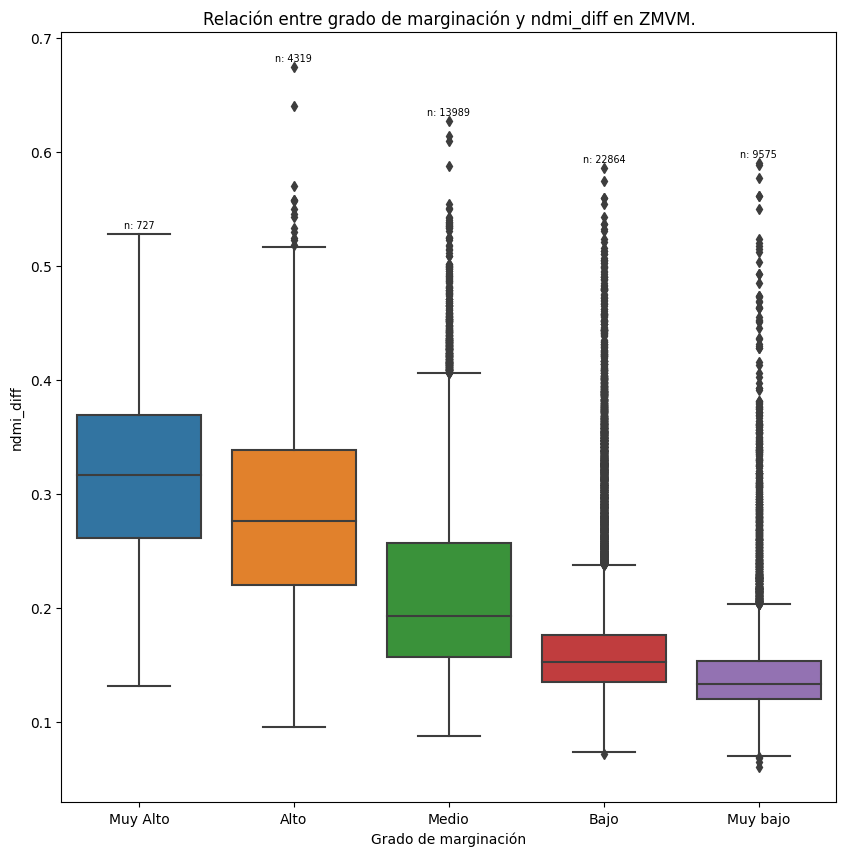

In [41]:
fig, ax = plt.subplots(figsize=(10,10))

#---------Plot
sns.boxplot(x=np.array(boxplot_gdf.Grado_Marg) , 
            y=np.array(boxplot_gdf.ndmi_diff), 
            ax=ax)

#---------Format
plt.title('Relación entre grado de marginación y ndmi_diff en {}.'.format(city))
plt.xlabel('Grado de marginación')
plt.ylabel('ndmi_diff')

# ------------------------------------------- Add number of hex per marginalization group -------------------------------------------

#---------Position
#Calculate max of each Marginalization group to position number of observations above each boxplot
maxs = boxplot_gdf.groupby(['Grado_Marg'])['ndmi_diff'].max()
num_maxs = maxs.values
#Drop NaNs
num_maxs = num_maxs[~np.isnan(num_maxs)]

#---------Count
#Calculate number of observations per group
obs = boxplot_gdf['Grado_Marg'].value_counts()
obs = obs.reset_index()
obs = obs.sort_values('index')
print(obs)
#Drop Ceros by turning them to nans
obs = obs['Grado_Marg'].apply(lambda x: np.nan if x==0 else x)
obs = obs[~np.isnan(obs)]

num_obs = obs.values
num_obs = [str(x) for x in num_obs.tolist()]
num_obs = ["n: " + i for i in num_obs]

#---------Add it to the plot
pos = range(len(num_obs))
for tick,label in zip(pos,ax.get_xticklabels()):
    #ax.text(x,y,text)
    ax.text(pos[tick],
            num_maxs[tick] + 0.005,
            num_obs[tick],
            horizontalalignment='center',
            size='x-small',
            color='black')
# ------------------------------------------- ------------------------------------------- -------------------------------------------

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_marg_boxplot_{}.svg".format(city.lower(),city.lower()))

## Analysis 3 - ndmi_diff (humidity variation/conservation) extremes (10%max, 10%min)

### Analysis 3 Data treatment - Find mins and maxs ndmi_diff

Find 10% mins and 10% maxs ndmi_diff (ndmi_diff_extremes)

In [42]:
# Finding len of 10% of current city data
tenpercent = int(len(data_withveg)/10)

#Finding smallest and largest ndmi_diff
ndmi_diff_mins = data_withveg.nsmallest(tenpercent,'ndmi_diff')
ndmi_diff_maxs = data_withveg.nlargest(tenpercent,'ndmi_diff')

#Create maxs and mins category
ndmi_diff_mins['ndmi_diff_cat'] = '10%_mins'
ndmi_diff_maxs['ndmi_diff_cat'] = '10%_maxs'

#Concatenate to one data layer
ndmi_diff_extremes = pd.concat([ndmi_diff_mins, ndmi_diff_maxs])

print(ndmi_diff_extremes.shape)
ndmi_diff_extremes.head(2)

(5178, 25)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,...,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndvi_median_rango,Grado_Marg,ndmi_diff_cat
48435,8a4995bac88ffff,"POLYGON ((-99.21299 19.42167, -99.21234 19.422...",10,0.365986,0.101774,0.412987,0.451287,0.231041,0.220246,-0.000870,...,0.103921,0.027096,0.104735,0.146982,0.086836,0.060146,-0.000670,Moderada densidad vegetal,Muy bajo,10%_mins
48700,8a4995bac2c7fff,"POLYGON ((-99.21617 19.43807, -99.21552 19.438...",10,0.338628,0.123819,0.386193,0.451677,0.178701,0.272976,-0.001239,...,0.116227,0.029468,0.117847,0.154599,0.090207,0.064392,-0.000529,Mínima densidad vegetal,Muy bajo,10%_mins


### Analysis 3 Data analysis [a] - Visual correlation analyisis

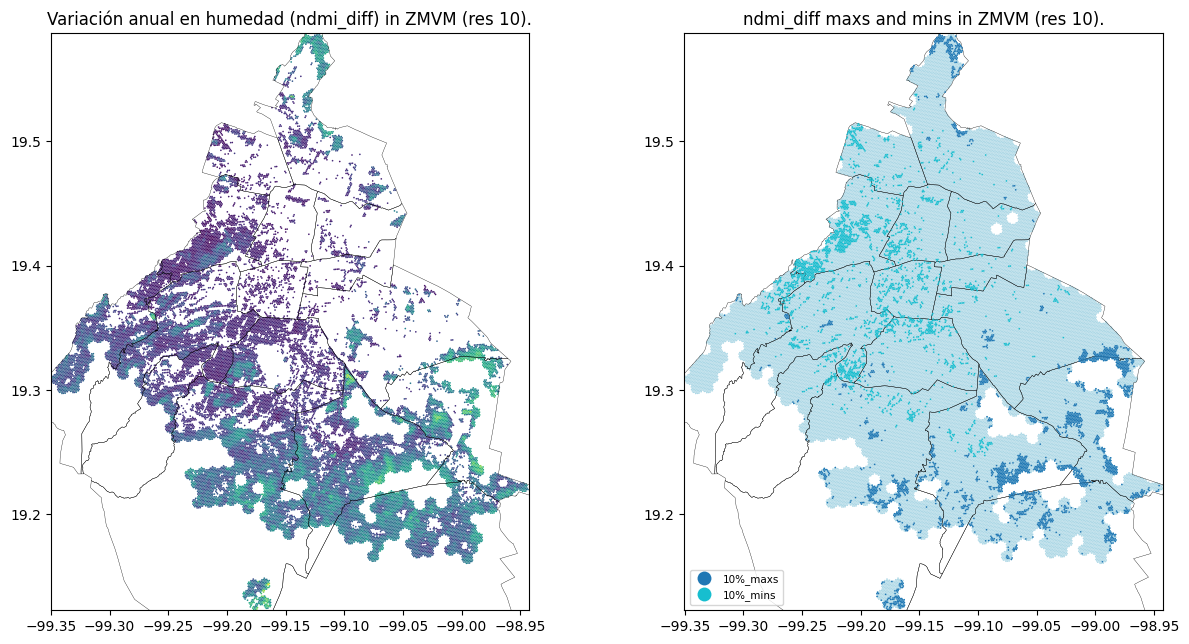

In [43]:
#Create figure
fig,ax = plt.subplots(1,2,figsize=(15,7.5))

#--------- First ax ---------
#Plotting ndmi_diff
data_withveg.plot('ndmi_diff', 'viridis', ax=ax[0], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[0], zorder = 1)

##---------Format
ax[0].set_title('Variación anual en humedad (ndmi_diff) in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[0].set_xlim(data_withveg.total_bounds[0], data_withveg.total_bounds[2])
ax[0].set_ylim(data_withveg.total_bounds[1], data_withveg.total_bounds[3])


#--------- Second ax ---------
#Plot base hexes
ndvi_ndmi_marg.plot(color = 'lightblue',ax=ax[1], zorder = 0)
#Plot municipalities
mun_gdf.plot(facecolor="none", edgecolor='black', lw=0.25, ax=ax[1], zorder = 1)
#Plot extremes data
ndmi_diff_extremes.plot('ndmi_diff_cat',ax=ax[1],zorder = 2, 
                        legend=True, legend_kwds={'fontsize':7.5,'loc':'lower left'})

##---------Format
ax[1].set_title('ndmi_diff maxs and mins in {} (res 10).'.format(city))

# Set the extents of the plot to match the base hexes data
ax[1].set_xlim(ndvi_ndmi_marg.total_bounds[0], ndvi_ndmi_marg.total_bounds[2])
ax[1].set_ylim(ndvi_ndmi_marg.total_bounds[1], ndvi_ndmi_marg.total_bounds[3])
#agregar pad

# ---------- Save Plot ----------
if save_plots:
    plt.savefig("../../../output/figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmidiff_minsandmaxs_{}.svg".format(city.lower(),city.lower()))

### Analysis 3 Data analysis [b] - Analyisis by municipality

In [54]:
#Reviewing process
print(data_withveg.columns.unique())
print(ndmi_diff_extremes.columns.unique())

Index(['hex_id', 'geometry', 'res', 'ndvi_mean', 'ndvi_std', 'ndvi_median',
       'ndvi_max', 'ndvi_min', 'ndvi_diff', 'ndvi_tend', 'city', 'pobtot',
       'im_2020', 'imn_2020', 'NOMGEO', 'ndmi_mean', 'ndmi_std', 'ndmi_median',
       'ndmi_max', 'ndmi_min', 'ndmi_diff', 'ndmi_tend', 'ndvi_median_rango',
       'Grado_Marg'],
      dtype='object')
Index(['hex_id', 'geometry', 'res', 'ndvi_mean', 'ndvi_std', 'ndvi_median',
       'ndvi_max', 'ndvi_min', 'ndvi_diff', 'ndvi_tend', 'city', 'pobtot',
       'im_2020', 'imn_2020', 'NOMGEO', 'ndmi_mean', 'ndmi_std', 'ndmi_median',
       'ndmi_max', 'ndmi_min', 'ndmi_diff', 'ndmi_tend', 'ndvi_median_rango',
       'Grado_Marg', 'ndmi_diff_cat'],
      dtype='object')


In [66]:
#Prepare data
totaldata_withveg = data_withveg.shape[0]

municipalities = mun_gdf.NOMGEO.unique()
count_df = pd.DataFrame(index=municipalities)
    
#Analize each municipality
for municipality in municipalities:
    
    #Count how many hexs with vegetation there are
    municipal_data_withveg = data_withveg.loc[data_withveg.NOMGEO==municipality]
    municipal_count = data_withveg.loc[data_withveg.NOMGEO==municipality].count()[0]
    avg_ndmi_diff = municipal_data_withveg.loc[:, 'ndmi_diff'].mean()
    med_ndmi_diff = municipal_data_withveg.loc[:, 'ndmi_diff'].median()
    
    # Add to DataFrame
    count_df.loc[municipality,'hexs_withveg'] = municipal_count
    count_df.loc[municipality,'cityshare(%)_hexs_withveg']= municipal_count/totaldata_withveg
    count_df.loc[municipality,'avg_ndmi_diff'] = avg_ndmi_diff
    count_df.loc[municipality,'med_ndmi_diff'] = med_ndmi_diff

    #Calculate %hexs belonging to 10%min and 10%max humidity variation/conservation
    municipal_extremes = ndmi_diff_extremes.loc[ndmi_diff_extremes.NOMGEO==municipality]    
    municipal_proportions = municipal_extremes.groupby('ndmi_diff_cat').count()
    
    # Add to DataFrame
    for min_or_max in municipal_proportions.index.unique().to_list():
        value = municipal_proportions.loc[min_or_max,'hex_id']
        count_df.loc[municipality,min_or_max] = value

#Data treatment and Format
count_df.fillna(0,inplace=True)
count_df['municipalityshare(%)_10%_mins'] = count_df['10%_mins']/count_df['hexs_withveg']
count_df['municipalityshare(%)_10%_maxs'] = count_df['10%_maxs']/count_df['hexs_withveg']
count_df['cityshare(%)_10%_mins'] = count_df['10%_mins']/(count_df['10%_mins'].sum())
count_df['cityshare(%)_10%_maxs'] = count_df['10%_maxs']/(count_df['10%_maxs'].sum())

#Reviewing process
count_df

,hexs_withveg,cityshare(%)_hexs_withveg,avg_ndmi_diff,med_ndmi_diff,10%_mins,10%_maxs,municipalityshare(%)_10%_mins,municipalityshare(%)_10%_maxs,cityshare(%)_10%_mins,cityshare(%)_10%_maxs
Azcapotzalco,345.0,0.013321,0.128432,0.117706,167.0,0.0,0.484058,0.000000,0.064504,0.000000
Coyoacán,1609.0,0.062128,0.155222,0.134338,262.0,20.0,0.162834,0.012430,0.101197,0.007725
Cuajimalpa de Morelos,1914.0,0.073905,0.187415,0.182014,163.0,17.0,0.085162,0.008882,0.062959,0.006566
Gustavo A. Madero,1190.0,0.045949,0.248926,0.242115,65.0,242.0,0.054622,0.203361,0.025106,0.093472
Iztacalco,162.0,0.006255,0.137894,0.131348,60.0,0.0,0.370370,0.000000,0.023175,0.000000
Iztapalapa,895.0,0.034559,0.246847,0.235787,94.0,177.0,0.105028,0.197765,0.036307,0.068366
La Magdalena Contreras,813.0,0.031392,0.164247,0.149332,62.0,5.0,0.076261,0.006150,0.023947,0.001931
Milpa Alta,3013.0,0.116341,0.280341,0.276880,0.0,376.0,0.000000,0.124793,0.000000,0.145230
Álvaro Obregón,2640.0,0.101938,0.160787,0.144414,400.0,22.0,0.151515,0.008333,0.154500,0.008497
Tláhuac,1776.0,0.068577,0.316720,0.312823,0.0,635.0,0.000000,0.357545,0.000000,0.245268


In [188]:
#---------------------------------------------------- %hexs with veg by municipality data ----------------------------------------------------
#Find centroids
data_withveg_calc = data_withveg.to_crs("EPSG:6372")
veg_centroids = data_withveg_calc.centroid
veg_centroids = veg_centroids.to_crs("EPSG:4326")

#Turn into gdf
veg_centroids_gdf = gpd.GeoDataFrame(veg_centroids)
veg_centroids_gdf = veg_centroids_gdf.rename(columns={0:'geometry'})

# Preform overlay with municipalities
mun_gdf = mun_gdf.set_crs("EPSG:4326")
withveg_centroids = gpd.overlay(veg_centroids_gdf,mun_gdf,keep_geom_type=True)

# Reviewing process
print(withveg_centroids.shape)
withveg_centroids.head(2)

(25898, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,city,geometry
0,09002,09,002,Azcapotzalco,ZMVM,POINT (-99.17998 19.46151)
1,09002,09,002,Azcapotzalco,ZMVM,POINT (-99.17820 19.46497)


In [189]:
#---------------------------------------------------- 10% mins and maxs data ----------------------------------------------------
#Find centroids
extremes_calc = ndmi_diff_extremes.to_crs("EPSG:6372")
calc_centroids = extremes_calc.centroid
calc_centroids = calc_centroids.to_crs("EPSG:4326")

#Turn into gdf
calc_centroids_gdf = gpd.GeoDataFrame(calc_centroids)
calc_centroids_gdf = calc_centroids_gdf.rename(columns={0:'geometry'})

#Re-join with data
calc_centroids_withdata = gpd.overlay(calc_centroids_gdf,ndmi_diff_extremes,keep_geom_type=True)
columns_tokeep = ['hex_id','ndmi_diff_cat','geometry']
calc_centroids_withdata = extremes_centroids_withdata[columns_tokeep]

#Preform overlay with municipalities
mun_gdf = mun_gdf.set_crs("EPSG:4326")
extreme_centroids = gpd.overlay(calc_centroids_withdata,mun_gdf,keep_geom_type=True)

# Reviewing process
print(extreme_centroids.shape)
extreme_centroids.head(2)

(5181, 8)


,hex_id,ndmi_diff_cat,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,city,geometry
0,8a4995bac88ffff,10%_mins,09016,09,016,Miguel Hidalgo,ZMVM,POINT (-99.21304 19.42241)
1,8a4995bac2c7fff,10%_mins,09016,09,016,Miguel Hidalgo,ZMVM,POINT (-99.21622 19.43880)


In [198]:
#Prepare data
totalcentroids_withvegs = withveg_centroids.shape[0]

municipalities = mun_gdf.NOMGEO.unique()
count_df = pd.DataFrame(index=municipalities)

    
#Analize each municipality
for municipality in municipalities:
    
    #Count how many hexs with vegetation there are
    municipality_withveg_centroids = withveg_centroids.loc[withveg_centroids.NOMGEO==municipality].count()[0]
    
    # Add to DataFrame
    count_df.loc[municipality,'withveg'] = municipality_withveg_centroids
    count_df.loc[municipality,'withveg_cityshare(%)']= municipality_withveg_centroids/totalcentroids_withvegs

    #Calculate %hexs belonging to 10%min and 10%max humidity variation/conservation
    municipality_extreme_centroids = extreme_centroids.loc[municipality_extremes.NOMGEO==municipality]
    municipality_proportions = municipality_extreme_centroids.groupby('ndmi_diff_cat').count()
    
    # Add to DataFrame
    for min_or_max in municipality_proportions.index.unique().to_list():
        value = municipality_proportions.loc[min_or_max,'hex_id']
        count_df.loc[municipality,min_or_max] = value


#Data treatment and Format
count_df.fillna(0,inplace=True)
count_df['10%_mins_municipalityshare(%)'] = count_df['10%_mins']/count_df['withveg']
count_df['10%_maxs_municipalityshare(%)'] = count_df['10%_maxs']/count_df['withveg']
count_df['10%_mins_cityshare(%)'] = count_df['10%_mins']/(count_df['10%_mins'].sum())
count_df['10%_maxs_cityshare(%)'] = count_df['10%_maxs']/(count_df['10%_maxs'].sum())


count_df

,withveg,withveg_cityshare(%),10%_mins,10%_maxs,10%_mins_municipalityshare(%),10%_maxs_municipalityshare(%),10%_mins_cityshare(%),10%_maxs_cityshare(%)
Azcapotzalco,345.0,0.013321,168.0,0.0,0.486957,0.000000,0.064740,0.000000
Coyoacán,1609.0,0.062128,263.0,20.0,0.163456,0.012430,0.101349,0.007734
Cuajimalpa de Morelos,1914.0,0.073905,165.0,17.0,0.086207,0.008882,0.063584,0.006574
Gustavo A. Madero,1190.0,0.045949,66.0,242.0,0.055462,0.203361,0.025434,0.093581
Iztacalco,162.0,0.006255,60.0,0.0,0.370370,0.000000,0.023121,0.000000
Iztapalapa,895.0,0.034559,94.0,176.0,0.105028,0.196648,0.036224,0.068059
La Magdalena Contreras,813.0,0.031392,62.0,5.0,0.076261,0.006150,0.023892,0.001933
Milpa Alta,3013.0,0.116341,0.0,375.0,0.000000,0.124461,0.000000,0.145012
Álvaro Obregón,2640.0,0.101938,401.0,22.0,0.151894,0.008333,0.154528,0.008507
Tláhuac,1776.0,0.068577,0.0,635.0,0.000000,0.357545,0.000000,0.245553


### Analysis 3 Data analysis - Clean data and export to csv

Clean gdf

In [28]:
columns_tokeep = ['hex_id','res','ndmi_diff','ndmi_diff_cat','im_2020','imn_2020','Grado_Marg','city','geometry']
ndmi_diff_extremes_c = ndmi_diff_extremes[columns_tokeep]
                  
#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(5236, 9)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry
49063,8a4995bac88ffff,10,0.060146,10%_mins,124.646879,0.973695,Muy bajo,ZMVM,"POLYGON ((-99.21299 19.42167, -99.21234 19.422..."
49026,8a4995bac2c7fff,10,0.064392,10%_mins,125.782130,0.982563,Muy bajo,ZMVM,"POLYGON ((-99.21617 19.43807, -99.21552 19.438..."


Data linear transformation in order to produce desired 3D map

In [29]:
#Linear intepolation data
x1 = ndmi_diff_extremes_c['ndmi_diff'].max()
y1 = ndmi_diff_extremes_c['ndmi_diff'].min()

x2 = ndmi_diff_extremes_c['ndmi_diff'].min()
y2 = ndmi_diff_extremes_c['ndmi_diff'].max()

m = (y2-y1)/(x2-x1)
b = y1-m*x1

# Convert all ndmi_diff to its opossite value in that linear interpolation (y=mx+b)
ndmi_diff_extremes_c['ndmi_diff_opossite'] = ndmi_diff_extremes_c['ndmi_diff'].apply(lambda x: m*x+b)

#Review result
print(ndmi_diff_extremes_c.shape)
ndmi_diff_extremes_c.head(2)

(5236, 10)


/usr/local/python/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,hex_id,res,ndmi_diff,ndmi_diff_cat,im_2020,imn_2020,Grado_Marg,city,geometry,ndmi_diff_opossite
49063,8a4995bac88ffff,10,0.060146,10%_mins,124.646879,0.973695,Muy bajo,ZMVM,"POLYGON ((-99.21299 19.42167, -99.21234 19.422...",0.674371
49026,8a4995bac2c7fff,10,0.064392,10%_mins,125.782130,0.982563,Muy bajo,ZMVM,"POLYGON ((-99.21617 19.43807, -99.21552 19.438...",0.670125


Export to csv

In [30]:
#Export to csv
if csv_dataset:
    csv_raster_dataset = ndmi_diff_extremes_c.copy()
    #Show dataframe
    print(csv_raster_dataset.shape)
    csv_raster_dataset.head(2)
    #Download dataframe
    csv_raster_dataset.to_csv("../../../output//figures/ndvi_ndmi_marg_bycity/{}/ndmi_diff/ndmi_diffextremes_marg_{}.csv".format(city.lower(),city.lower()))